In [2]:
import data_bert
import model_bert_evaluation_pipeline
import model_bert_tree_evaluation_pipeline
import model_bert_evaluation_helpers
import config
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
topics = data_bert.topics
topics_inv_map = pd.Series(data=np.arange(len(topics)), index=topics.index)
topic_trees = []
total_nodes = []
total_nodes_by_tid = np.empty(shape = len(topics), dtype="object")
for str_id in topics.loc[topics["level"] == 0].index:
    node = model_bert_tree_evaluation_pipeline.Node(level=0, topic_num_id=topics_inv_map[str_id], topic_str_id=str_id)
    topic_trees.append(node)
    total_nodes.append(node)
    total_nodes_by_tid[topics_inv_map[str_id]] = node

# generate tree structure
for level in range(np.max(topics["level"].unique())):
    for str_id in topics.loc[topics["level"] == (level + 1)].index:
        parent = model_bert_tree_evaluation_pipeline.find_node_by_str_id(total_nodes, topics.loc[str_id, "parent"])

        node = model_bert_tree_evaluation_pipeline.Node(level=(level+1), topic_num_id=topics_inv_map[str_id], topic_str_id=str_id)
        node.parent = parent
        parent.children.append(node)

        total_nodes.append(node)
        total_nodes_by_tid[node.topic_num_id] = node

topic_id_to_preorder_id = np.zeros(shape=len(total_nodes), dtype=np.int32)
topic_id_to_subtree_end = np.zeros(shape=len(total_nodes), dtype=np.int32)
preorder_id_to_topic_id = np.zeros(shape=len(total_nodes), dtype=np.int32)

cur_id = 0
for node in topic_trees:
    cur_id = model_bert_tree_evaluation_pipeline.compute_preorder_id(node, cur_id, topic_id_to_preorder_id, preorder_id_to_topic_id, topic_id_to_subtree_end) + 1

In [3]:
def compute_expanded_tree(node, min_subtree_size):
    for child in node.children:
        compute_expanded_tree(child, min_subtree_size)
    
    if node.subtree_end_id - node.preorder_id < min_subtree_size:
        cnode = node
        while cnode.parent is not None:
            cnode = cnode.parent
            if cnode.subtree_end_id - cnode.preorder_id >= min_subtree_size:
                break
        node.least_subtree = cnode
    else:
        node.least_subtree = node

In [4]:
mapping_dict = {}
for min_expand in range(1,30):
    for node in topic_trees:
        compute_expanded_tree(node, min_expand)
    mapping = np.zeros(shape = len(data_bert.topics), dtype=np.int32)
    for k in range(len(data_bert.topics)):
        topic_str_id = data_bert.topics.index[k]
        node = total_nodes_by_tid[k]
        mapping[k] = node.least_subtree.topic_num_id
    mapping_dict[min_expand] = mapping

Computed metrics of 0 out of 49523
0.0009670257568359375
Computed metrics of 200 out of 49523
2.947065830230713
Computed metrics of 400 out of 49523
3.1009981632232666
Computed metrics of 600 out of 49523
3.1369688510894775
Computed metrics of 800 out of 49523
2.880030632019043
Computed metrics of 1000 out of 49523
2.983969211578369
Computed metrics of 1200 out of 49523
3.1690306663513184
Computed metrics of 1400 out of 49523
3.1659698486328125
Computed metrics of 1600 out of 49523
3.1660001277923584
Computed metrics of 1800 out of 49523
3.1560299396514893
Computed metrics of 2000 out of 49523
2.874967098236084
Computed metrics of 2200 out of 49523
2.928032875061035
Computed metrics of 2400 out of 49523
2.922968626022339
Computed metrics of 2600 out of 49523
3.1520309448242188
Computed metrics of 2800 out of 49523
3.0380022525787354
Computed metrics of 3000 out of 49523
3.0320005416870117
Computed metrics of 3200 out of 49523
3.1459665298461914
Computed metrics of 3400 out of 49523
3.1

Computed metrics of 28800 out of 49523
2.7669990062713623
Computed metrics of 29000 out of 49523
2.7339982986450195
Computed metrics of 29200 out of 49523
2.590031385421753
Computed metrics of 29400 out of 49523
2.6759696006774902
Computed metrics of 29600 out of 49523
2.5340306758880615
Computed metrics of 29800 out of 49523
2.8869709968566895
Computed metrics of 30000 out of 49523
3.813664197921753
Computed metrics of 30200 out of 49523
4.022750616073608
Computed metrics of 30400 out of 49523
3.767000913619995
Computed metrics of 30600 out of 49523
3.46999454498291
Computed metrics of 30800 out of 49523
3.6540026664733887
Computed metrics of 31000 out of 49523
3.4960341453552246
Computed metrics of 31200 out of 49523
3.36496639251709
Computed metrics of 31400 out of 49523
2.878997564315796
Computed metrics of 31600 out of 49523
3.2580008506774902
Computed metrics of 31800 out of 49523
3.207031488418579
Computed metrics of 32000 out of 49523
3.187967538833618
Computed metrics of 32200

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
1,0.788703,0.008923,0.984593,0.038996,0.998680,0.002512,0.012433,0.984593,0.015445
2,0.790717,0.002234,0.969634,0.010838,0.999489,0.001277,0.006352,0.969634,0.030405
3,0.790829,0.001992,0.965303,0.009704,0.999584,0.001118,0.005564,0.965303,0.034736
4,0.790889,0.001805,0.960570,0.008809,0.999613,0.000984,0.004900,0.960570,0.039469
5,0.790910,0.001613,0.955591,0.007885,0.999619,0.000874,0.004353,0.955591,0.044448
6,0.791011,0.001422,0.950435,0.006971,0.999649,0.000783,0.003902,0.950435,0.049603
7,0.791051,0.001293,0.946408,0.006344,0.999661,0.000724,0.003610,0.946408,0.053631
8,0.791055,0.001161,0.942564,0.005705,0.999667,0.000676,0.003369,0.942564,0.057475
9,0.791116,0.001061,0.939141,0.005221,0.999685,0.000638,0.003180,0.939141,0.060898
10,0.791116,0.000968,0.935583,0.004769,0.999685,0.000602,0.003005,0.935583,0.064456


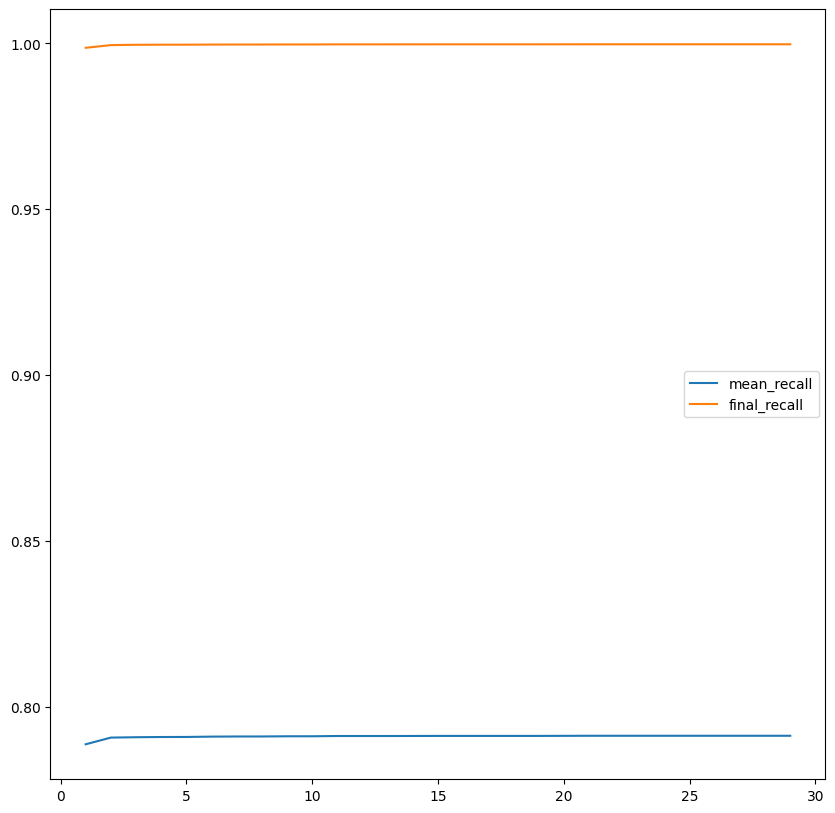

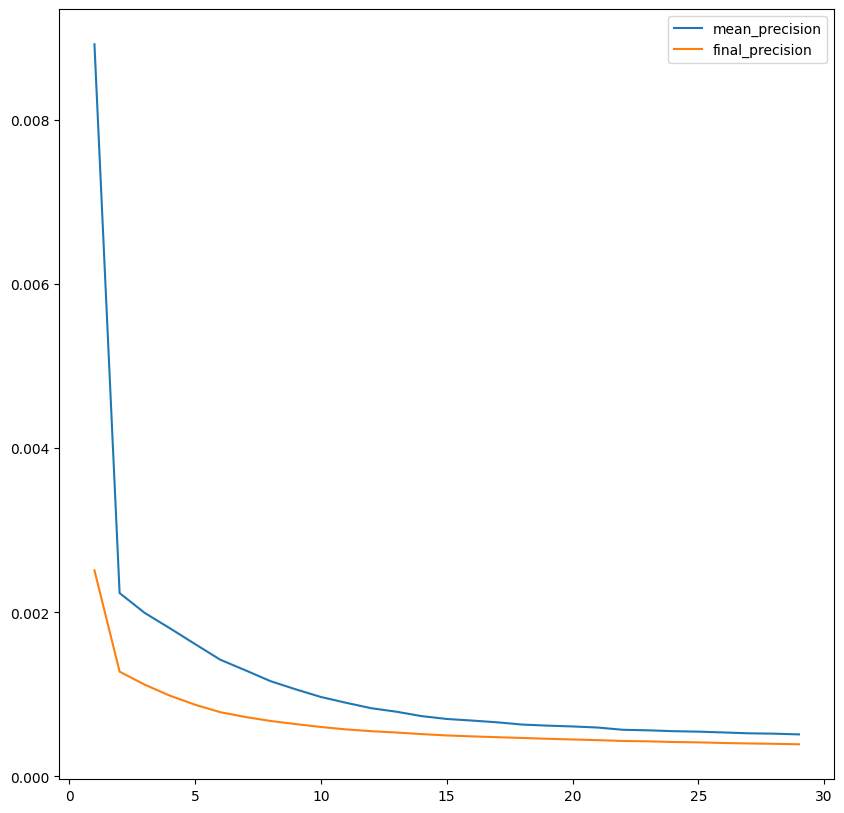

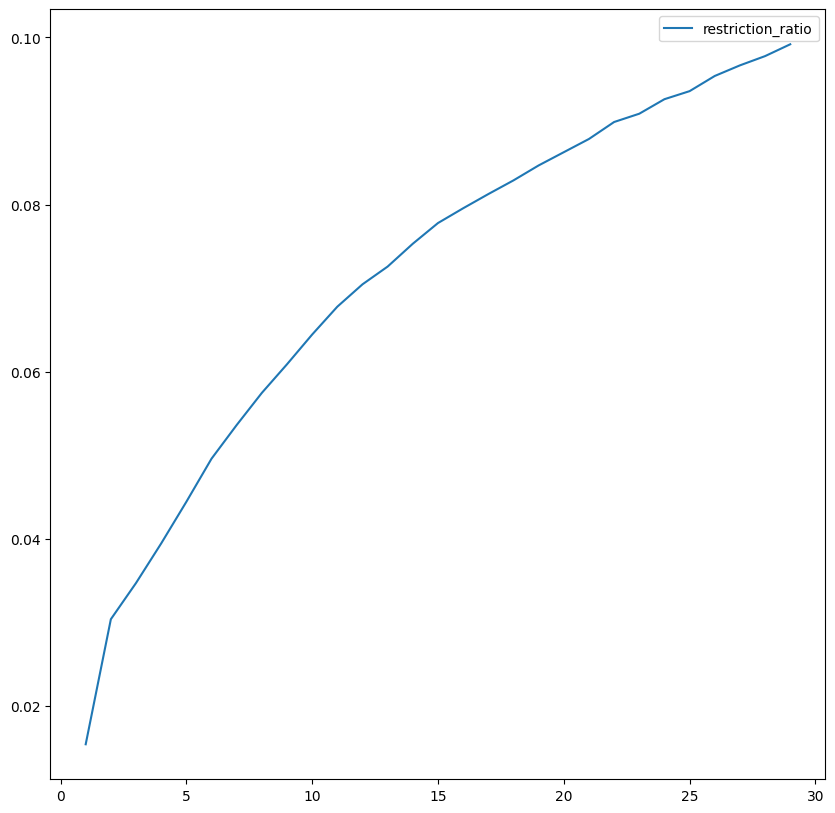

In [6]:
folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train/"
cors_arr = np.empty(shape = len(topics), dtype = "object")
for k in range(len(topics)):
    if os.path.isfile(folder + str(k) + ".npy"):
        row_preds = set(list(np.load(folder + str(k) + ".npy")))
    else:
        row_preds = set()
    cors_arr[k] = row_preds

dframe = model_bert_evaluation_helpers.evaluate_quality_from_cors_arr(mapping_dict, data_bert.train_topics_num_id,
                                                                   data_bert.train_contents_num_id, cors_arr)
display(dframe)
dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
plt.show()
dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
plt.show()
dframe[["restriction_ratio"]].plot(figsize = (10, 10))
plt.show()

Computed metrics of 0 out of 25338
0.03463935852050781
Computed metrics of 200 out of 25338
2.654400587081909
Computed metrics of 400 out of 25338
2.5232021808624268
Computed metrics of 600 out of 25338
2.7684662342071533
Computed metrics of 800 out of 25338
2.690870523452759
Computed metrics of 1000 out of 25338
2.823066473007202
Computed metrics of 1200 out of 25338
2.8262522220611572
Computed metrics of 1400 out of 25338
2.956693410873413
Computed metrics of 1600 out of 25338
3.126713514328003
Computed metrics of 1800 out of 25338
2.765002965927124
Computed metrics of 2000 out of 25338
2.5550901889801025
Computed metrics of 2200 out of 25338
3.0149970054626465
Computed metrics of 2400 out of 25338
2.7740039825439453
Computed metrics of 2600 out of 25338
3.4480319023132324
Computed metrics of 2800 out of 25338
3.7729673385620117
Computed metrics of 3000 out of 25338
3.5900001525878906
Computed metrics of 3200 out of 25338
3.2150027751922607
Computed metrics of 3400 out of 25338
3.442

,mean_recall,mean_precision,mean_accuracy,mean_f2,final_recall,final_precision,final_f2,final_accuracy,restriction_ratio
1,0.646867,0.005774,0.949967,0.023740,0.789170,0.001098,0.005462,0.949967,0.050074
2,0.756050,0.001088,0.872834,0.005254,0.928388,0.000509,0.002537,0.872834,0.127226
3,0.760070,0.000950,0.860684,0.004653,0.934201,0.000467,0.002331,0.860684,0.139377
4,0.765675,0.000851,0.841534,0.004187,0.941136,0.000414,0.002065,0.841534,0.158527
5,0.771681,0.000748,0.814694,0.003689,0.948968,0.000357,0.001781,0.814694,0.185369
6,0.776570,0.000653,0.789203,0.003221,0.954913,0.000316,0.001576,0.789203,0.210860
7,0.781301,0.000567,0.764531,0.002805,0.960131,0.000284,0.001419,0.764531,0.235533
8,0.784867,0.000503,0.743748,0.002493,0.964068,0.000262,0.001309,0.743748,0.256317
9,0.787815,0.000459,0.726753,0.002275,0.967166,0.000247,0.001232,0.726753,0.273312
10,0.789907,0.000412,0.709338,0.002044,0.970255,0.000233,0.001162,0.709338,0.290727


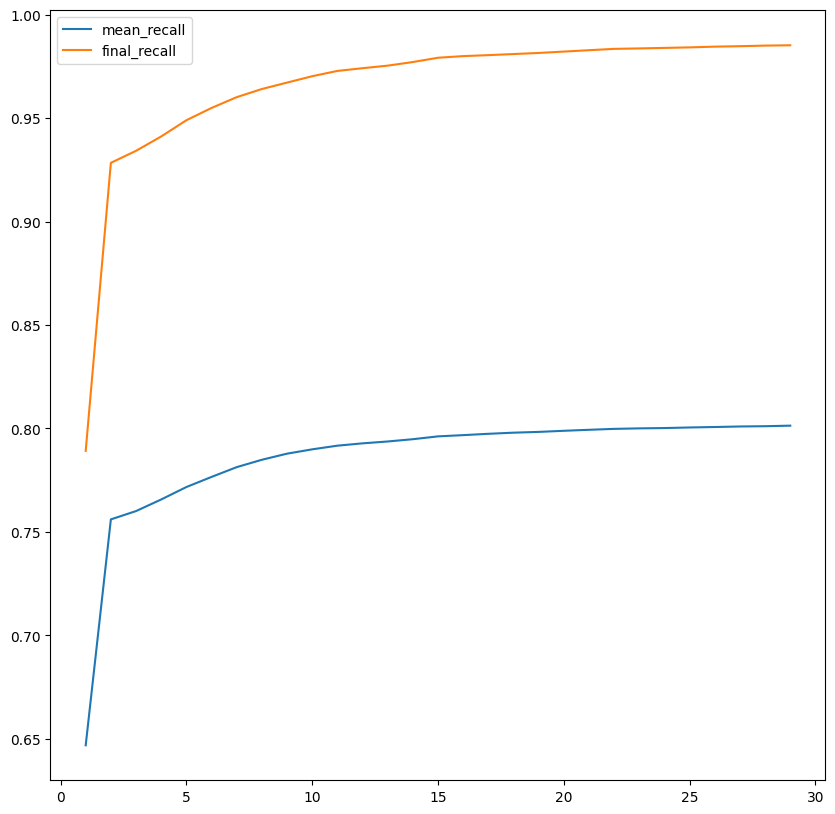

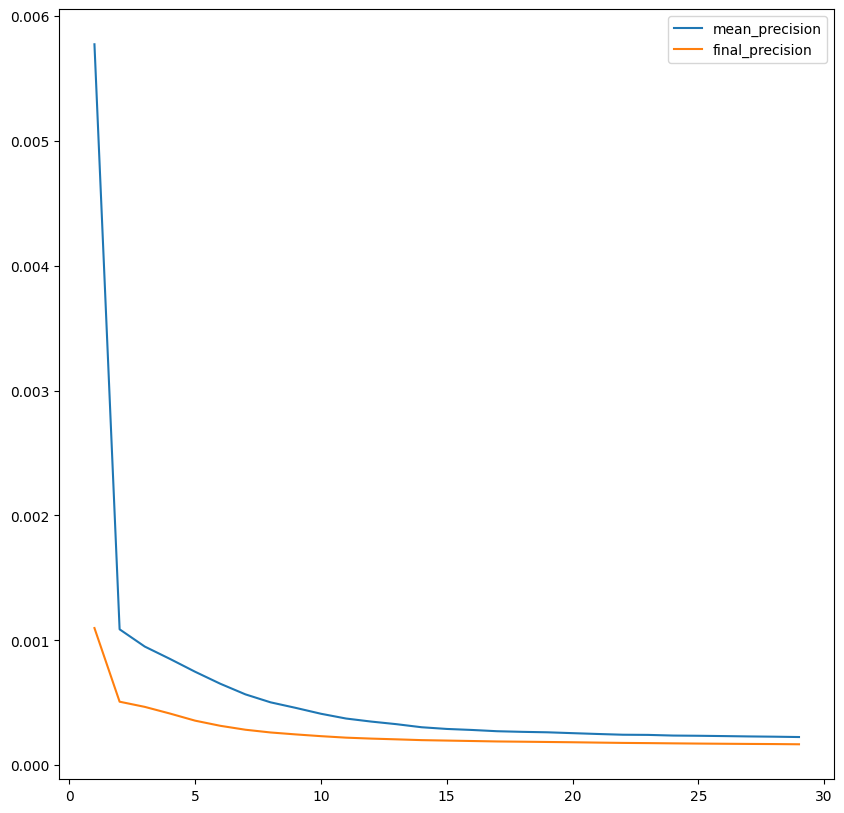

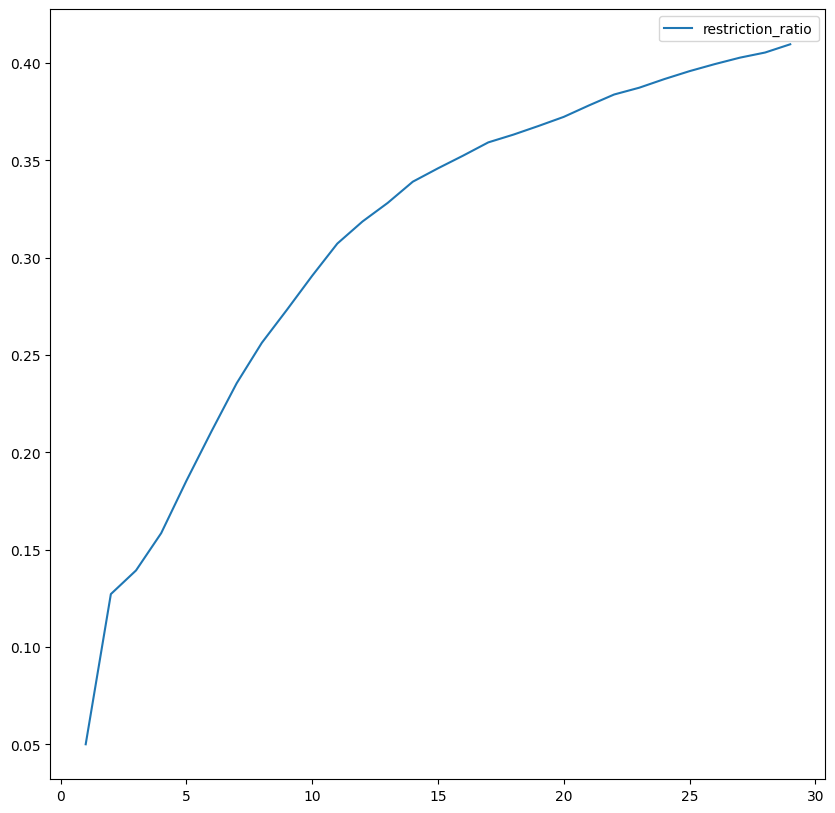

In [8]:
folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test/"
cors_arr = np.empty(shape = len(topics), dtype = "object")
for k in range(len(topics)):
    if os.path.isfile(folder + str(k) + ".npy"):
        row_preds = set(list(np.load(folder + str(k) + ".npy")))
    else:
        row_preds = set()
    cors_arr[k] = row_preds

dframe = model_bert_evaluation_helpers.evaluate_quality_from_cors_arr(mapping_dict, data_bert.test_topics_num_id,
                                                                   data_bert.test_contents_num_id, cors_arr)
display(dframe)
dframe[["mean_recall", "final_recall"]].plot(figsize = (10, 10))
plt.show()
dframe[["mean_precision", "final_precision"]].plot(figsize = (10, 10))
plt.show()
dframe[["restriction_ratio"]].plot(figsize = (10, 10))
plt.show()

In [4]:
# seems best to pick 7 as the overshoot.
expand = 7
for node in topic_trees:
    compute_expanded_tree(node, expand)
mapping = np.zeros(shape = len(data_bert.topics), dtype=np.int32)
for k in range(len(data_bert.topics)):
    topic_str_id = data_bert.topics.index[k]
    node = total_nodes_by_tid[k]
    mapping[k] = node.least_subtree.topic_num_id

In [5]:
train_stuff_folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train/"
test_stuff_folder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test/"

In [7]:
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/"

if not os.path.isdir(mfolder):
    os.mkdir(mfolder)

mtopics = []
mcontents = []
saved_files_lengths = []
saved_files = 0

for topic_num_id in data_bert.train_topics_num_id:
    mapped_id = mapping[topic_num_id]
    if os.path.isfile(train_stuff_folder + str(mapped_id) + ".npy"):
        cors = np.load(train_stuff_folder + str(mapped_id) + ".npy")
        mcontents.extend(list(cors))
        mtopics.extend(list(np.repeat(topic_num_id, len(cors))))
        if len(mcontents) > 67108864:
            assert len(mcontents) == len(mtopics)
            np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
            np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
            saved_files_lengths.append(len(mcontents))
            saved_files += 1
            
            del mtopics, mcontents
            mtopics = []
            mcontents = []

np.save(mfolder + str(saved_files) + "_contents.npy", np.array(mcontents, dtype=np.int32))
np.save(mfolder + str(saved_files) + "_topics.npy", np.array(mtopics, dtype=np.int32))
saved_files_lengths.append(len(mcontents))
saved_files += 1
del mtopics, mcontents
np.save(mfolder + "saved_files_lengths.npy", np.array(saved_files_lengths, dtype=np.int32))

In [8]:
def check_order(mfolder):
    saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")

    for file_id in range(len(saved_files_lengths)):
        content_ids = np.load(mfolder + str(file_id) + "_contents.npy")
        topic_ids = np.load(mfolder + str(file_id) + "_topics.npy")
        assert (topic_ids[1:] < topic_ids[:-1]).sum() == 0
        
        for topic_num_id in np.unique(topic_ids):
            left = np.searchsorted(topic_ids, topic_num_id, side="left")
            right = np.searchsorted(topic_ids, topic_num_id, side="right")
            contents_restrict_ids = content_ids[left:right]
            assert (contents_restrict_ids[1:] <= contents_restrict_ids[:-1]).sum() == 0
        
        del content_ids, topic_ids
check_order(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test_COMBINE/")
check_order(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/")

In [5]:
def check_inclusion(mfolder, train_or_test):
    saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")

    for file_id in range(len(saved_files_lengths)):
        content_ids = np.load(mfolder + str(file_id) + "_contents.npy")
        topic_ids = np.load(mfolder + str(file_id) + "_topics.npy")
        
        if train_or_test == "train":
            assert (~data_bert.fast_contains_multi(data_bert.train_contents_num_id, content_ids)).sum() == 0
            assert (~data_bert.fast_contains_multi(data_bert.train_topics_num_id, topic_ids)).sum() == 0
        else:
            assert (~data_bert.fast_contains_multi(data_bert.test_contents_num_id, content_ids)).sum() == 0
            assert (~data_bert.fast_contains_multi(data_bert.test_topics_num_id, topic_ids)).sum() == 0
        
        del content_ids, topic_ids
        print(file_id)
check_inclusion(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test_COMBINE/", "test")
print("done")
check_inclusion(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/", "train")

0
1
2
3
4
done
0
1
2
3


In [9]:
has_cors_content_ids = []
has_cors_topic_ids = []
def extend_correlations(mfolder):
    saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")

    for file_id in range(len(saved_files_lengths)):
        content_ids = np.load(mfolder + str(file_id) + "_contents.npy")
        topic_ids = np.load(mfolder + str(file_id) + "_topics.npy")

        contains = data_bert.has_correlations_general(data_bert.has_correlation_contents, data_bert.has_correlation_topics,
                                          content_ids, topic_ids).astype(dtype=np.int32).astype(dtype=bool)

        has_cors_content_ids.extend(list(data_bert.has_correlation_contents[contains]))
        has_cors_topic_ids.extend(list(data_bert.has_correlation_topics[contains]))
        del content_ids, topic_ids

extend_correlations(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_test_COMBINE/")
extend_correlations(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/")

In [11]:
has_cors_topic_ids = np.array(has_cors_topic_ids, dtype=np.int32)
has_cors_content_ids = np.array(has_cors_content_ids, dtype=np.int32)
sidx = np.argsort(has_cors_topic_ids)
has_cors_topic_ids = has_cors_topic_ids[sidx]
has_cors_content_ids = has_cors_content_ids[sidx]

for topic_num_id in np.unique(has_cors_topic_ids):
    left = np.searchsorted(has_cors_topic_ids, topic_num_id, side="left")
    right = np.searchsorted(has_cors_topic_ids, topic_num_id, side="right")
    assert (has_cors_topic_ids[left:right] - has_cors_topic_ids[left]).sum() == 0
    
    sub_contents = has_cors_content_ids[left:right]
    has_cors_content_ids[left:right] = np.sort(sub_contents)

In [12]:
def check_order_generated(content_ids, topic_ids):
    assert (topic_ids[1:] < topic_ids[:-1]).sum() == 0

    for topic_num_id in np.unique(topic_ids):
        left = np.searchsorted(topic_ids, topic_num_id, side="left")
        right = np.searchsorted(topic_ids, topic_num_id, side="right")
        contents_restrict_ids = content_ids[left:right]
        assert (contents_restrict_ids[1:] <= contents_restrict_ids[:-1]).sum() == 0
check_order_generated(has_cors_content_ids, has_cors_topic_ids)

In [15]:
np.save(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_cors_topics.npy", has_cors_topic_ids)
np.save(config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_cors_contents.npy", has_cors_content_ids)

In [4]:
mfolder = config.resources_path + "model_eval_tree/" + "topics_tree_overshoot_small_trained_on_train_eval_train_COMBINE/"
saved_files_lengths = np.load(mfolder + "saved_files_lengths.npy")
print(saved_files_lengths)

[67115047 67110285 67109973 30812312]
